# Preprocessing

Load DBS all channal data   
Bipolar referencing   
High pass filter    

In [1]:
import scipy
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Analysis
from scipy import signal
from neurodsp.spectral import compute_spectrum
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
from neurodsp.filt import filter_signal
from neurodsp.plts.time_series import plot_time_series

In [2]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/fuq01' 
# Specify subject names 
subj_ids = ['701','702','705','814','815']

mat_dict = {f'{x}': [] for x in subj_ids}
elec_dict = {f'{x}': [] for x in subj_ids}

In [3]:
elec_channal = ['CRAW_01', 'CRAW_02', 'CRAW_03', 'CRAW_04', 'CRAW_05', 'CMacro_RAW_01', 'CMacro_RAW_02', 'CMacro_RAW_03']
elec_dic = {'ring 0': 'CLFP1', 'seg 1A': 'CLFP2', 'seg 1B': 'CLFP3', 'seg 1C': 'CLFP4', 'seg 2A': 'CLFP5', 'seg 2B': 'CMacro LFP1', 'seg 2C': 'CMacro LFP1', 'ring 3': 'CMacro LFP3'}

In [4]:
def load_mat(dir_files):
    data_all = []
    for m in dir_files:
        file = scipy.io.loadmat(m)
        data_all.append(file)
    return data_all

In [19]:
sub_dir = f'{base_dir}/Documents/GitHub/leap-analysis/LFP/data/702'
mat_file = load_mat(glob.glob(f'{sub_dir}/*.mat'))
example_data = mat_file[0]

In [20]:
ref1 = example_data['CRAW_01'] - example_data['CRAW_02']
ref2 = example_data['CRAW_01'] - example_data['CRAW_03']
ref3 = example_data['CRAW_01'] - example_data['CRAW_04']

ref4 = example_data['CMacro_RAW_03'] - example_data['CRAW_05']
ref5 = example_data['CMacro_RAW_03'] - example_data['CMacro_RAW_01']
ref6 = example_data['CMacro_RAW_03'] - example_data['CMacro_RAW_02']
 

In [21]:
def downsample(lfp, hz, downsample_factor):
    '''
    Downsample signal by a factor of downsample_factor
    '''
    signal_ds = signal.decimate(lfp.flatten(), downsample_factor)
    signal_hz = hz/downsample_factor
    if np.mod(hz, downsample_factor) != 0:
        raise ValueError('Sampling rate must be an integer after downsampling. Check your factor')
    return signal_ds, signal_hz

In [22]:
orginal_hz = example_data['CRAW_01_KHz'].flatten()*1000
ref1_ds, ref1_hz = downsample(ref1, orginal_hz, 44)

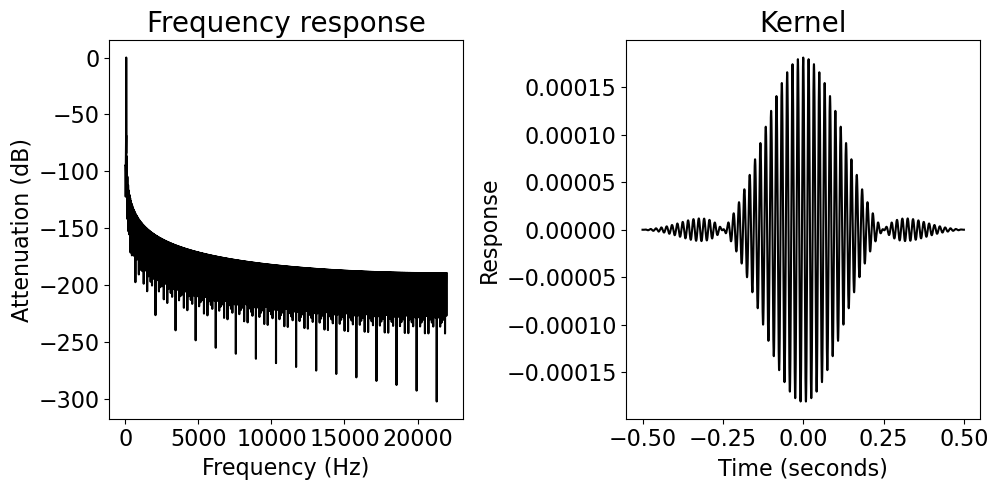

In [8]:
# line noise filter
orginal_hz = example_data['CRAW_01_KHz'].flatten()*1000
raw = example_data['CRAW_02'].flatten()
ref1 = ref1.flatten()

f_range = (58, 62)
sig_filt = filter_signal(ref1, orginal_hz, 'bandpass', f_range, n_seconds=1, plot_properties=True)

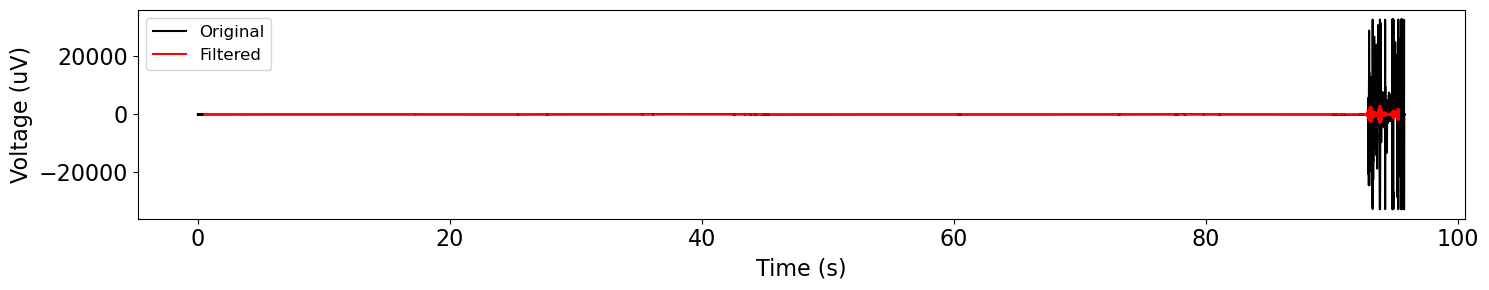

In [9]:
from neurodsp.utils import create_times
second = len(ref1)/orginal_hz
times = create_times(second[0], orginal_hz)
plot_time_series(times, [ref1, sig_filt], ['Original','Filtered'])

In [72]:
sig_filt

array([ nan, -47., -44., ...,   0.,   0.,  nan])

In [13]:
orginal_hz = example_data['CRAW_01_KHz'].flatten()*1000
ref1_ds, ref1_hz = downsample(ref1, orginal_hz, 44)

In [23]:
ref1_ds

array([  3.8679384 ,  -1.71790115,   0.49502942, ..., -53.08285645,
       -53.94662726, -54.08799102])

In [24]:
len(ref1_ds.flatten()), len(ref1.flatten())

(62495, 2749761)

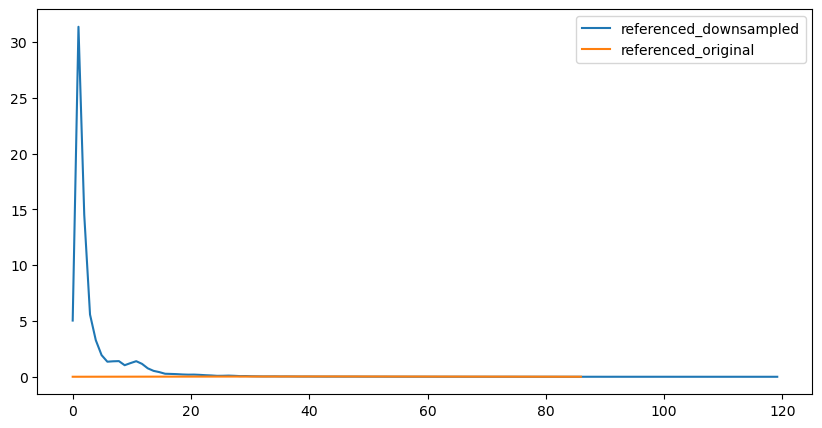

In [26]:
freq_mean1, psd_mean1 = compute_spectrum(ref1_ds.flatten(), ref1_hz, method='welch', avg_type='mean', nperseg=1024)
freq_mean2, psd_mean2 = compute_spectrum(ref1.flatten(), orginal_hz, method='welch', avg_type='mean', nperseg=1024)

new_freq1 = freq_mean1[freq_mean1<120]
new_psd1 = psd_mean1[freq_mean1<120]

new_freq2 = freq_mean2[freq_mean2<120]
new_psd2 = psd_mean2[freq_mean2<120]

plt.figure(figsize=(10, 5))
plt.plot(new_freq1, new_psd1, label='referenced_downsampled')
plt.plot(new_freq2, new_psd2, label='referenced_original')
plt.legend()

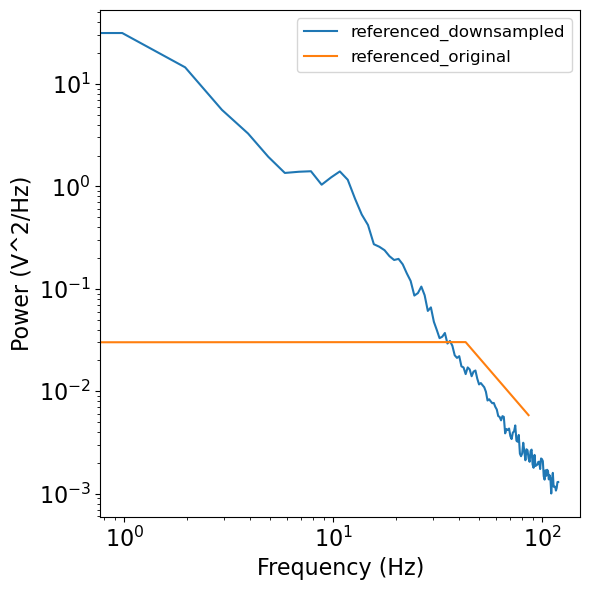

In [27]:
from neurodsp.plts.spectral import plot_power_spectra
plot_power_spectra([new_freq1, new_freq2], [new_psd1, new_psd2],['referenced_downsampled', 'referenced_original'], log_freqs=True)